# Preprocessamento delle immagini in formato .geojson
Prima di iniziare a lavorare con le immagini che ho, devo convertire le label da un formato .geojson ad un formato .tiff per poterle utilizzare come ground truth del mio dataset. Questa operazione la svolgo in questo notebook di preprocessamento.

La prima operazione che svolgo è configurare il percorso dei dati impostando la variabile data_path al percorso della cartella contenente i dati. In seguito vado a controllare se la cartella specificata in data_path esiste effettivamente nel file system. Se non esiste, mando un messaggio di errore. In questo modo vado a verificare se riesco ad accedere ai dati su cui devo lavorare.

In [1]:
import os
import preprocessing


data_path = '../data/train/AOI_11_Rotterdam'

print(f"Percorso dei dati configurato: {data_path}")

# Verifica se il percorso esiste
if not os.path.isdir(data_path):
    print(f"\nERRORE: La cartella dei dati non è stata trovata a '{data_path}'.")
    print("Controlla la tua struttura di directory e il valore di 'data_path'.")
else:
    print("Percorso dei dati verificato con successo.")

Percorso dei dati configurato: ../data/train/AOI_11_Rotterdam
Percorso dei dati verificato con successo.


Dopo aver verificato che posso accedere ai dati corretti, eseguo la mia funzione di preprocessamento che va a rasterizzare i file .geojson in maschere binarie. Le maschere rasterizzate vengono poi salvate nella sottocartella 'rasterized_masks'.

In [2]:
print("Inizio il processo di pre-elaborazione...")
# Esegue la funzione importata, passandole il percorso corretto
preprocessing.preprocess_spacenet6_data(data_path)
print("Processo di pre-elaborazione terminato.")

Inizio il processo di pre-elaborazione...
La cartella di output per le maschere rasterizzate è: ../data/train/AOI_11_Rotterdam/rasterized_masks
Trovati 3401 file SAR. Inizio la rasterizzazione...
Processing 1/3401 files. Elapsed time: 0.00 seconds.
Processing 100/3401 files. Elapsed time: 3.14 seconds.
Processing 200/3401 files. Elapsed time: 6.50 seconds.
Processing 300/3401 files. Elapsed time: 10.06 seconds.
Processing 400/3401 files. Elapsed time: 13.00 seconds.
Processing 500/3401 files. Elapsed time: 16.05 seconds.
Processing 600/3401 files. Elapsed time: 18.61 seconds.
Processing 700/3401 files. Elapsed time: 21.08 seconds.
Processing 800/3401 files. Elapsed time: 23.94 seconds.
Processing 900/3401 files. Elapsed time: 27.28 seconds.
Processing 1000/3401 files. Elapsed time: 30.82 seconds.
Processing 1100/3401 files. Elapsed time: 33.84 seconds.
Processing 1200/3401 files. Elapsed time: 36.98 seconds.
Processing 1300/3401 files. Elapsed time: 40.05 seconds.
Processing 1400/3401 

Vado infine a fare un test, stampando alcune immagini e le rispettive maschere, per verificare che la rasterizzazione è avvenuta correttamente.

Trovate 3401 maschere rasterizzate.

--- Visualizzazione per il file: SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6259.tif ---


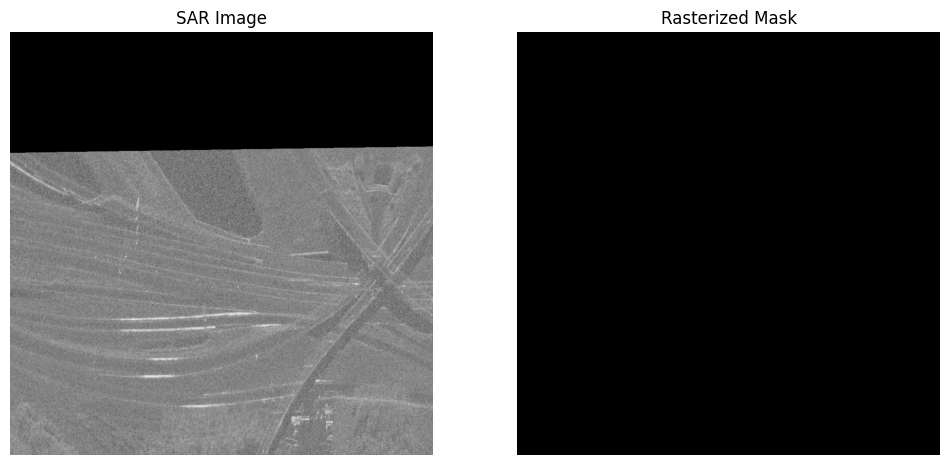


--- Visualizzazione per il file: SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823074026_20190823074323_tile_2210.tif ---


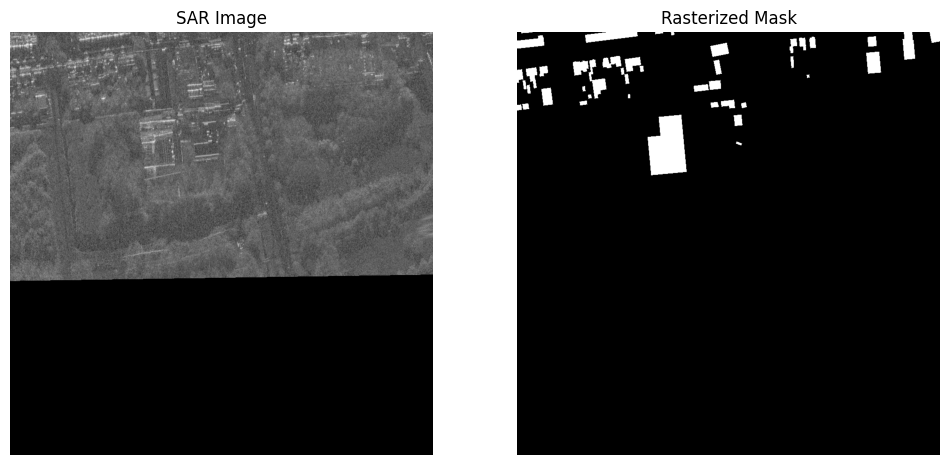


--- Visualizzazione per il file: SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823094036_20190823094408_tile_10265.tif ---


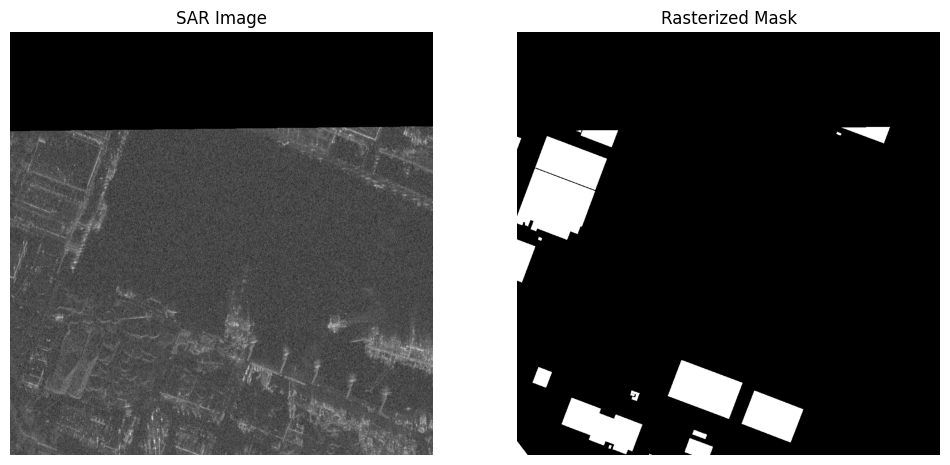

In [3]:
import matplotlib.pyplot as plt
import rasterio
import os 

rasterized_masks_dir = os.path.join(data_path, 'rasterized_masks')
sar_intensity_dir = os.path.join(data_path, 'SAR-Intensity')

# Ottieni alcuni nomi di file di esempio
mask_files = [f for f in os.listdir(rasterized_masks_dir) if os.path.isfile(os.path.join(rasterized_masks_dir, f)) and f.endswith('.tif')]

if not mask_files:
    print(f"Nessuna maschera '.tif' trovata in {rasterized_masks_dir}. Il processo di pre-elaborazione potrebbe non aver funzionato o la cartella è vuota.")
else:
    print(f"Trovate {len(mask_files)} maschere rasterizzate.")
    
    # Visualizza le prime 3 coppie SAR-Mask
    num_examples_to_show = min(3, len(mask_files))
    
    for i in range(num_examples_to_show):
        base_name = os.path.splitext(mask_files[i])[0]
        mask_path = os.path.join(rasterized_masks_dir, mask_files[i])
        sar_path = os.path.join(sar_intensity_dir, f"{base_name}.tif")

        if os.path.exists(sar_path) and os.path.exists(mask_path):
            print(f"\n--- Visualizzazione per il file: {base_name}.tif ---") # Stampa il nome del file 
            
            with rasterio.open(sar_path) as sar_src:
                sar_img = sar_src.read(1) # Primo canale per visualizzazione
                
            with rasterio.open(mask_path) as mask_src:
                mask_img = mask_src.read(1) # Maschera binaria (bianco/nero)

            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(sar_img, cmap='gray')
            plt.title('SAR Image') # Titolo generico per il subplot
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask_img, cmap='gray')
            plt.title('Rasterized Mask') # Titolo generico per il subplot
            plt.axis('off')
            
            plt.show()
        else:
            print(f"File SAR o maschera non trovati per {base_name}. Impossibile visualizzare.")

Prima di passare alla creazione della classe per il dataset, verifico se le dimensioni delle immagini sono sempre le stesse o se devo fare un ridimensionamento.

In [4]:
import os
import rasterio


if 'data_path' not in locals():
    print("Errore: 'data_path' non è definito. Esegui la prima cella del notebook.")
else:
    sar_intensity_dir = os.path.join(data_path, 'SAR-Intensity')
    
    if not os.path.isdir(sar_intensity_dir):
        print(f"Errore: Cartella SAR non trovata a: {sar_intensity_dir}")
    else:
        print(f"Analisi delle dimensioni delle immagini SAR in: {sar_intensity_dir}")
        
        sar_files = [f for f in os.listdir(sar_intensity_dir) if f.endswith('.tif')]
        total_files = len(sar_files)
        
        if total_files == 0:
            print("Nessun file .tif trovato nella cartella SAR.")
        else:
            print(f"Trovati {total_files} file SAR. Verifico le dimensioni...")
            
            # Utilizzo un insieme per metterci dentro tutte le dimensioni uniche, in questo modo se un valore su ripete, non ho duplicati
            unique_dimensions = set()
            
            for i, sar_filename in enumerate(sar_files):
                sar_path = os.path.join(sar_intensity_dir, sar_filename)
                
                try:
                    with rasterio.open(sar_path) as src:
                        height = src.height
                        width = src.width
                        current_dimensions = (height, width)
                        
                        unique_dimensions.add(current_dimensions)
                        
                        
                except Exception as e:
                    print(f"Errore nella lettura di {sar_filename}: {e}")
            
            print("\n--- Riassunto delle Dimensioni Immagini SAR ---")
            if len(unique_dimensions) == 1:
                print(f"Tutte le immagini SAR hanno la stessa dimensione: {list(unique_dimensions)[0]}")
            else:
                print("Le immagini SAR hanno dimensioni diverse:")
                for dim in sorted(list(unique_dimensions)): 
                    print(f"- {dim}")
            
            print("\nAnalisi dimensioni completata.")

Analisi delle dimensioni delle immagini SAR in: ../data/train/AOI_11_Rotterdam/SAR-Intensity
Trovati 3401 file SAR. Verifico le dimensioni...

--- Riassunto delle Dimensioni Immagini SAR ---
Tutte le immagini SAR hanno la stessa dimensione: (900, 900)

Analisi dimensioni completata.


Dato che tutte le immagini risultano avere le stesse dimensioni, non devo fare nessun ridimensionamento. Posso passare quindi alla creazione della classe per il Dataset per il caricamento dei dati.